In [8]:
from skimage import data, exposure, filters, io, segmentation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile as tif
sns.set()
from skimage.filters import gaussian, threshold_otsu
%matplotlib inline

In [9]:
def Vector(x, y, image_2D, savepath):
    
    ## Import picture as array
    
    # im = io.imread(loadpath)
    im = image_2D
    
    ## Set dendritic branching point(dbp) as the maximum value
    
    im[y, x] = 255
    
    ## Save image
    
    io.imsave('%s.png' % savepath, im)
    
    ## Define dbp with the input index (y, x)

    dbp = np.array([y, x])
    
    ## Retrieve the index of all pixel values above a threshold
    
    # pixel_co = np.argwhere(im > np.quantile(im, 0.90))
    pixel_co = np.argwhere(im)        
    
    
    ## Substract the dbp index from every pixel to calculate the vectors
    
    norm_pixel_values = pixel_co - dbp
    
    norm_pixel_values[:,0]*= -1
   
    ## Find vector length to every pixel
    
    vec_length = np.linalg.norm(norm_pixel_values, axis=1)

    ## Delete dbp index
    
    dbp_index = np.argwhere(vec_length == 0)
    
    norm_pixel_values = np.delete(norm_pixel_values, (dbp_index), axis=0)
    
    vec_length = np.delete(vec_length, dbp_index)

    
    ## Normalize vector length 
    
    norm_vectors = norm_pixel_values / vec_length[:, np.newaxis]
    
    ## Add all vectors together 
    
    ori_vec = [norm_vectors.sum(axis=0)]
    
    ## Calculate length of the sum vector
    
    ori_vec_length = np.linalg.norm(ori_vec)
    
    ## Calculate normalized vector in the same orientation as sum vector
    
    norm_ori_vec = ori_vec / ori_vec_length  
    num_pixel = norm_pixel_values.shape[0]

    ## Calculate DGI
    
    DGI = np.divide(ori_vec_length, num_pixel)
    
    ## Plot the vector starting at the dbp in the image together with the used pixels as a scatterplot
    
    ax = plt.subplot(111)
    
    ax.scatter( norm_pixel_values[:, 1], norm_pixel_values[:, 0], marker = '.', alpha = 0.5)
    ax.arrow( 0, 0, 50*norm_ori_vec[0, 1], 50*norm_ori_vec[0,0], width = 1, head_width= 5, head_length=5, fc='k', ec='k')
    ax.axis('equal')
    plt.savefig('%s_scatter.png' % savepath, dpi = 1000)
    
    
    plt.show()
    
    ## Save Data to csv file
    
    np.savetxt("%s.csv" % savepath, norm_vectors, fmt="%.10f", delimiter=',')
    print(num_pixel)
    return(norm_ori_vec, norm_vectors, DGI, num_pixel)
            

In [68]:
def mask_image(volume, return_mask = False ,sig = 1):
    """
    Create a binary mask from a 2 or 3-dimensional np.array.
    Method normalizes the image, converts it to greyscale, then applies gaussian bluring (kernel width set to 2 by default, can be changed with sig parameter).
    This is followed by thresholding the image using the isodata method and returning a binary mask. 
    Parameters
    ----------
    image           np.array
                    np.array of an image (2 or 3D)
    return_mask     bool
                    If False (default), the mask is subtracted from the original image. If True, a boolian array is returned, of the shape of the original image, as a mask. 
    sig             Int
                    kernel width for gaussian smoothing. set to 2 by default.
    Returns
    -------
    mask            np.array
                    Returns a binary np.array of equal shape to the original image, labeling the masked area.
    """
    # for i in tqdm(range(1), desc = '3D_mask'):
    image = volume.copy()
    image = image.astype('float32')
    # normalize to the range 0-1
    image -= image.min()
    image /= image.max()
    # blur and grayscale before thresholding
    blur = gaussian(image, sigma=sig)
    # perform adaptive thresholding
    t = threshold_otsu(blur)
    mask = blur > t
    # convert to bool
    mask = np.array(mask, dtype=bool)
    if return_mask == False:
        image[mask==False] = 0
        mask = image
    return mask

In [137]:
loadpath = '/Users/aichah/Desktop/TLI/data/300322_B4O2D1_layer4_x86_y350.tif'
image_2D = tif.imread(loadpath)
image_2D.shape

(469, 299)

In [138]:
# image_2D = image_2D[85,:,1]
# image_2D = image_2D.max(axis=0)

In [139]:
image_2D.min(), image_2D.max()

(0, 255)

In [140]:
mask = mask_image(image_2D, return_mask = False ,sig = 1)

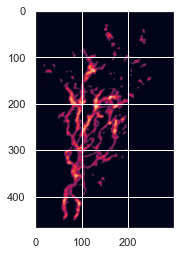

In [141]:
plt.imshow(mask)

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


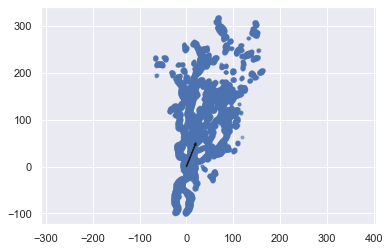

17295


In [142]:
savepath = '/Users/aichah/Desktop/TLI/data/montage/'
a, b, c, d = Vector(86,350, mask, savepath)


In [143]:
a

array([[0.92774644, 0.37321112]])

In [144]:
def dendritic_polarplot(sine, cos, nbins, norm_ori_vec, DGI, savepath, num_pixel, num_pixel_Adult):
    
  ## Convert vector coordinates into degree
    angles = np.arctan2(cos, sine)
    vec_angles = np.degrees(angles)
    
    ## Separate the vectors into different bins according to directions
    
    histo = np.histogram(vec_angles, bins = nbins)
    # histo = np.array(histo)
    
    ## Colour the bars differently
    
    cmap_hist = sns.husl_palette(nbins)
    
    ## Normalize the bar length (Normalized to Adult pixel number)
    
    bar_length = []
    for elem in histo[0]:
        bar_length.append(elem/num_pixel_Adult)
    bar_length.append(0)
    bar_length = np.array(bar_length)
    
    ## Add the normalized orientation vector of the dendrite
    
    ori_angle = np.degrees(np.arctan2(-norm_ori_vec[0, 1], -norm_ori_vec[0, 0]))
    
    ## Round DSI to 3 decimals
    
    DGI = round(DGI, 4)
    
    ## Make polar plot and add vector
    
    ax = plt.subplot(111, polar=True)
    
    bins = np.arange(0.0, 2*np.pi, 2*np.pi/nbins)
    bars = ax.bar(-bins-(np.pi/2), 3*bar_length[:-1], width = np.repeat(2*np.pi/nbins, nbins), bottom=0.0, alpha = 0.4)
    arrow = ax.arrow((-ori_angle/180*np.pi)-np.pi/2, 0, 0, (DGI*(num_pixel/num_pixel_Adult)), 
                    head_width = 0.08, head_length = 0.05,label = DGI, fc='k', ec='k')
    
    ax.set_rticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8])
    ax.set_yticklabels(['', '', '', '', '', '', '', ''])
    # plt.tick_params(
    #                 axis='x',          # changes apply to the x-axis
    #                 which='both',      # both major and minor ticks are affected
    #                 bottom=False,      # ticks along the bottom edge are off
    #                 top=False,         # ticks along the top edge are off
    #                 labelbottom=False) # labels along the bottom edge are off
    ax.set_rlabel_position(-ori_angle+90)
#     legend = ax.legend(loc = 'upper right', bbox_to_anchor=(1.08,1.08), handles = [arrow])
    # ax.set_xticklabels(['', '', '', '', '', '', '', ''])
#     plt.setp(plt.gca().get_legend().get_texts(), fontsize='16')
    
    for i in range(len(bars)):
        bars[i].set_facecolor(cmap_hist[i])
        bars[i].set_alpha(0.4)
        bars[i].set_edgecolor('k')
    plt.savefig('%s_plot.png' % savepath, dpi = 1000)
    plt.show()

    print(bar_length)
    
    return True

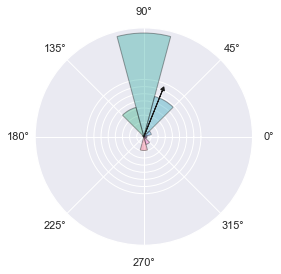

[0.06498988 0.00370049 0.00161897 0.00156114 0.00792136 0.14102342
 0.48360798 0.19358196 0.03607979 0.01503325 0.01295172 0.03793004
 0.        ]


In [145]:
z= dendritic_polarplot(b[:,0], b[:,1], 12, a, c, savepath, d, d)